# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

欢迎来到对象检测推理演练!这个笔记本将带您一步一步地通过使用一个预先训练的模型来检测图像中的对象的过程。确保在开始之前遵循[安装说明](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/install.md)。

## 该文件需位于object_detection文件夹下, jupyter notebook需要基于research文件打开

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# 将上层目录导入进来，这样才可以执行这下面的两条导入命令
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [2]:
# This is needed to display the images.
# 这条命令让在使用matplotlib绘图时，不在使用窗口展示出来，而是直接在notebook中显示
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

下面是来自对象检测模块的导入。

In [5]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables
- 导入包后，设置需要使用的模型

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

使用' export_inference_graph导出的任何模型。只需将“PATH_TO_FROZEN_GRAPH”更改为指向一个新的.pb文件，就可以在这里加载py '工具。
默认情况下，我们在这里使用“带Mobilenet的SSD”模型。查看[detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)可以以不同的速度和精度运行的其他模型的列表。

In [6]:
# What model to download.
# 使用的模型名称，下面会下载这个模型
# 修改一
MODEL_NAME = 'voc'  # 模型名称
# MODEL_FILE = MODEL_NAME + '.tar.gz'  # 模型所对应的文件
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'  # 模型的下载路径

# Path to frozen detection graph. This is the actual model that is used for the object detection.
# frozen_inference_graph.pb文件就是在后面需要导入的文件，他保存了网络的结构和数据
# 修改二：
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/export/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
# mscoco_label_map.pbtxt中保存了index到类别名的映射
# 如神经网络的预测类别是5，必须要通过这个文件才能知道index具体对应的类别是什么
# mscoco_label_map.pbtxt就保存在object_detection/data文件夹下，读者可以自行打开查阅
# 修改三：
PATH_TO_LABELS = os.path.join('voc', 'pascal_label_map.pbtxt')

## Download Model
- 接下来下载预训练模型，根据网络环境的不同，下载的时间可能会有长有短
- 这里的程序组合了DOWNLOAD_BASE和MODEL_FILE两个变量得到了下载地址。
- 很显然，由于MODEL_FILE的值是'ssd_mobilenet_v1_coco_2017_11_17.tar.gz'，因此下载的模型为SSD + MobileNet
- 如何下载其他预训练模型并执行：
    - 可以打开TensorFlow detection model zoo找到其他模型的下载地址。根据这些下载地址，只需要改变MODEL_FILE的值就可以下载不同的模型。
    - https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

In [7]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.
- 下载模型后，程序就直接将它读取到默认的计算图中（实际读取的是forzen_inference_graph.pb文件），使用的代码如下所示：

In [8]:
# 新建一个计算图
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
# PATH_TO_CKPT指向了文件frozen_inference_graph.pb
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

标签映射将索引映射到类别名称，因此当卷积网络预测“5”时，我们知道这对应于“飞机”。这里我们使用内部实用函数，但是任何返回字典映射整数到适当字符串标签的函数都可以

In [9]:
# 这部分代码的功能是将神经网络检测得到的index（数字）转换为类别名（字符串）
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [10]:
# 这个函数也是方便使用的帮助函数功能是将图片转换为Numpy数组的形式
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection
- 下面开始检测图片，先定义要检测的图片
- TEST_IAMGE_PATHS是一个列表，他保存了需要检测的图片。这里检测的图片是官方提供的示例图片。
- 如果想要检测自己的图片，只要将这些图片的路径以列表形式保存在TEST_IMAGE_PATHS中就可以了。

In [14]:
# For the sake of simplicity we will use only 2 images:
# 只检测两张图片
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
# 输出图像的大小
IMAGE_SIZE = (12, 8)

### 最后是检测的代码

In [15]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors 获取输入和输出张量的句柄
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image 下面的处理仅针对单个图像
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension 按照惯例，添加回batch维度
        tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      # 所有输出都是float32 numpy数组，因此要根据需要转换类型
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

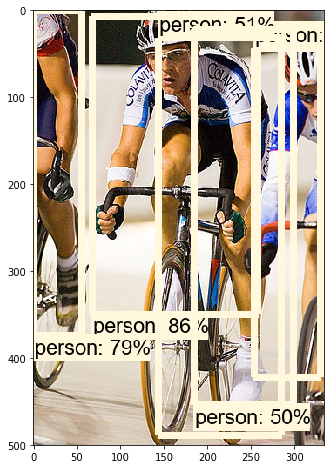

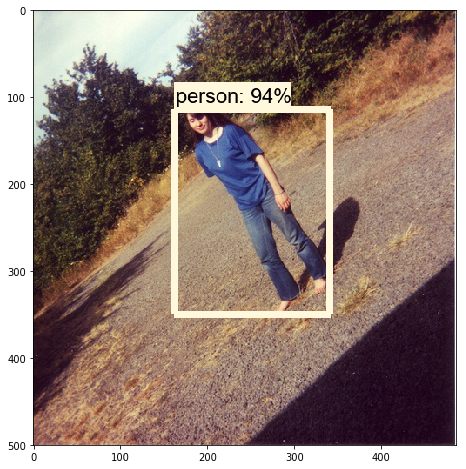

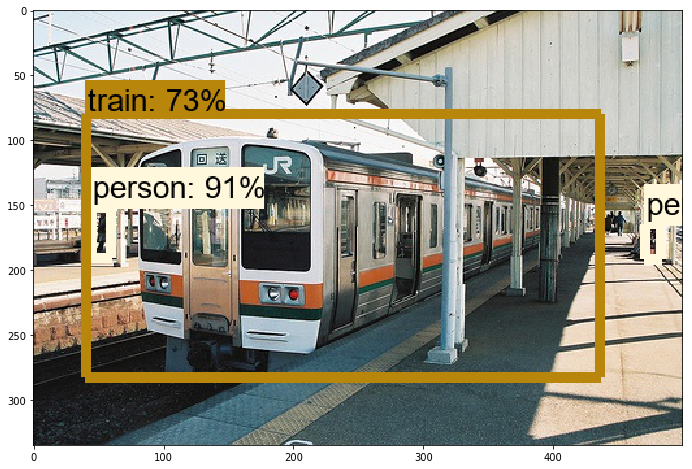

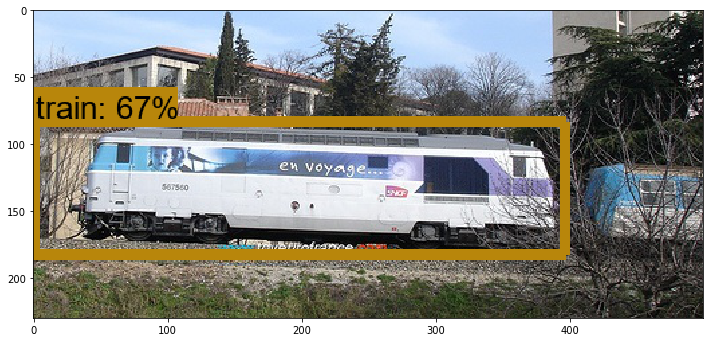

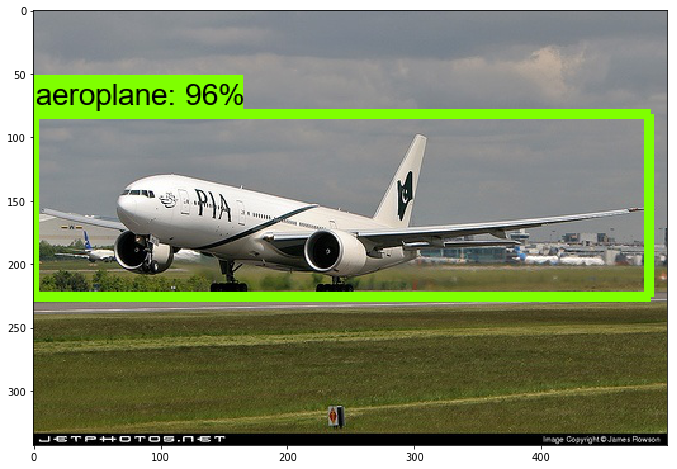

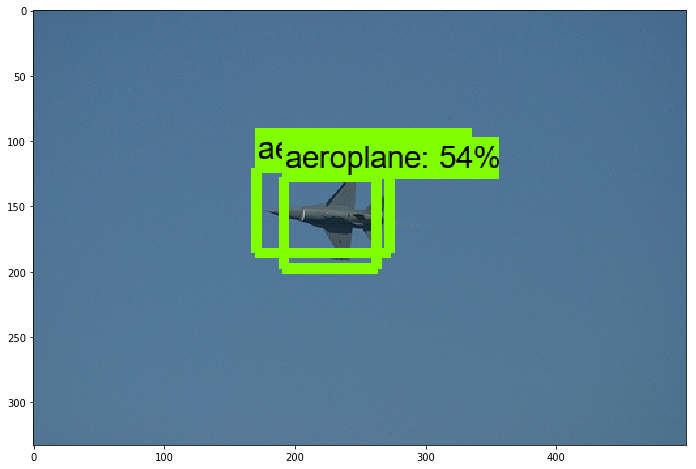

In [16]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  # 将图片扩展一维，最后进入神经网络的图片的格式应该为[1, ?, ?, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection. 检测结果的可视化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)